

# Project: Investigate a Dataset - [noshow appointment]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
Data Analytics is important for a business to grow and gives the organisation's a leverage to move ahead from competition and change business trends.
### Dataset Description 
No-show appointments: dataset from kaggel website collects information from 100k medical appointments focused on the question
of whether or not patients show up
for their appointment. 

### Question(s) for Analysis
 What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?
 
 
 Do sms messages affect attendance ?
 
 Do chronic diseases affect attendance?
 
 Does age affect attendance?
 
 Does sex affect attendance? 


In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline


In [140]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


In [141]:
!pip update --force-reinstall pandas 

ERROR: unknown command "update"


In [142]:
url='https://d17h27t6h515a5.cloudfront.net/topher/2017/October/59dd2e9a_noshowappointments-kagglev2-may-2016/noshowappointments-kagglev2-may-2016.csv'
df = pd.read_csv(url)
df.head(10) 
 

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [143]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object

In [144]:
df.shape

(110527, 14)

Number of rows=110527
Number of columns = 14

In [145]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


min age = -1 (wrong value )

max age = 115 

mean = 37

std= 23


In [161]:
df.duplicated().sum()

0

no duplicates

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


no missing data all of this 110527
(float -int-object)


In [147]:
mask = df.query('Age=="-1"')
mask

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


Delete the illogical age

In [148]:
df.drop(df.index[99832], axis=0, inplace=True)
df

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No
5,9.598513e+13,5626772,F,2016-04-27T08:36:51Z,2016-04-29T00:00:00Z,76,REPÚBLICA,0,1,0,0,0,0,No
6,7.336882e+14,5630279,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,3.449833e+12,5630575,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No
9,7.812456e+13,5629123,F,2016-04-27T12:48:25Z,2016-04-29T00:00:00Z,19,CONQUISTA,0,0,0,0,0,0,No


In [149]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105260e+05,1.105260e+05,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000,110526.000000
mean,1.474934e+14,5.675304e+06,37.089219,0.098266,0.197248,0.071865,0.030400,0.022248,0.321029
std,2.560943e+14,7.129544e+04,23.110026,0.297676,0.397923,0.258266,0.171686,0.161543,0.466874
min,3.921784e+04,5.030230e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172536e+12,5.640285e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680572e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.438963e+13,5.725523e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [ ]:
df.drop(['Scholarship', 'Alcoholism', 'Handcap','PatientId'], axis = 1, inplace = True)
df.head(10)

Delete unused columns 

In [151]:
df.rename(columns={'ScheduledDay':'Scheduled_Day'},inplace=True)
df.rename(columns={'AppointmentDay':'Appointment_Day'},inplace=True)
df.rename(columns={'Hipertension':'Hypertension'},inplace=True)
df.rename(columns={'No-show':'No_show'},inplace=True)
df.head() 

,AppointmentID,Gender,Scheduled_Day,Appointment_Day,Age,Neighbourhood,Hypertension,Diabetes,SMS_received,No_show
0,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,1,0,0,No
1,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,No
2,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,No
3,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,No
4,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,1,1,0,No


Correct some words  

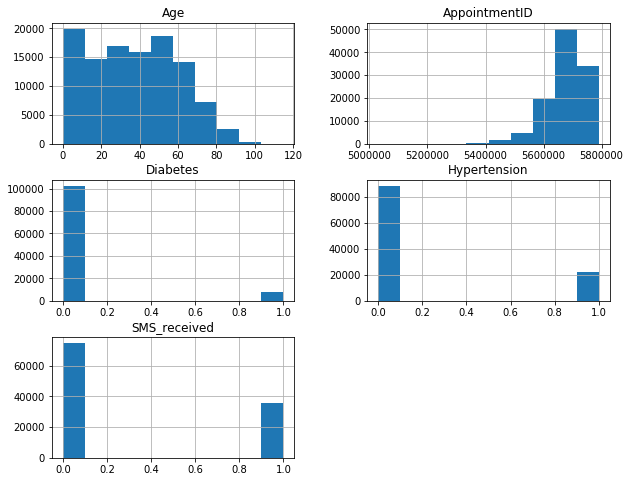

In [152]:
df.hist(figsize=(10,8));

who has Hypertension more than those without hypertension
  who has diabest more than those without diabest
  who not recevied sms is more than those recevied sms 

In [153]:
show = df.No_show =='No'
noshow = df.No_show =='Yes'

In [154]:
df[show].count()

AppointmentID      88207
Gender             88207
Scheduled_Day      88207
Appointment_Day    88207
Age                88207
Neighbourhood      88207
Hypertension       88207
Diabetes           88207
SMS_received       88207
No_show            88207
dtype: int64

number of those who showed =88207

In [155]:
df[noshow].count()

AppointmentID      22319
Gender             22319
Scheduled_Day      22319
Appointment_Day    22319
Age                22319
Neighbourhood      22319
Hypertension       22319
Diabetes           22319
SMS_received       22319
No_show            22319
dtype: int64

number of those who noshowed = 22319

Text(0,0.5,'Number')

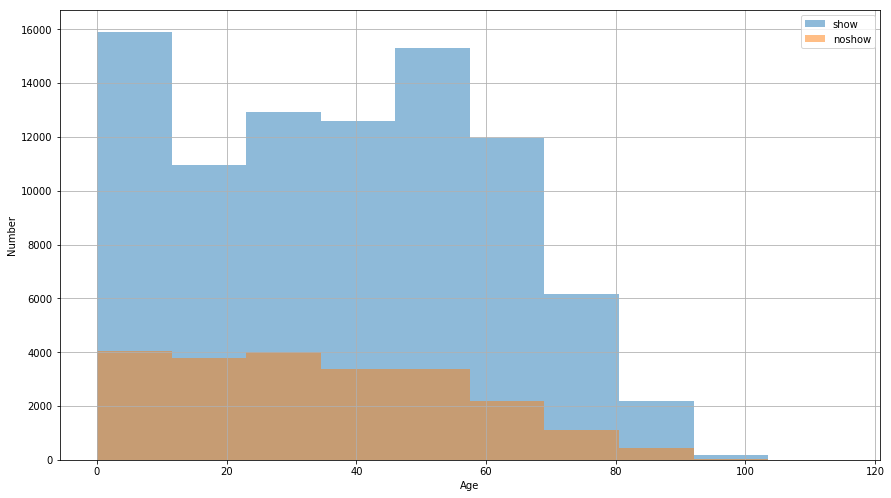

In [163]:
# Does age affect attendance?
plt.figure(figsize=[14.7, 8.27])
df.Age[show].hist(alpha = 0.5, label = 'show')
df.Age[noshow].hist(alpha = 0.5,label = 'noshow')
plt.legend()
plt.xlabel("Age")
plt.ylabel("Number")

It doesn't affect.

Text(0,0.5,'Number')

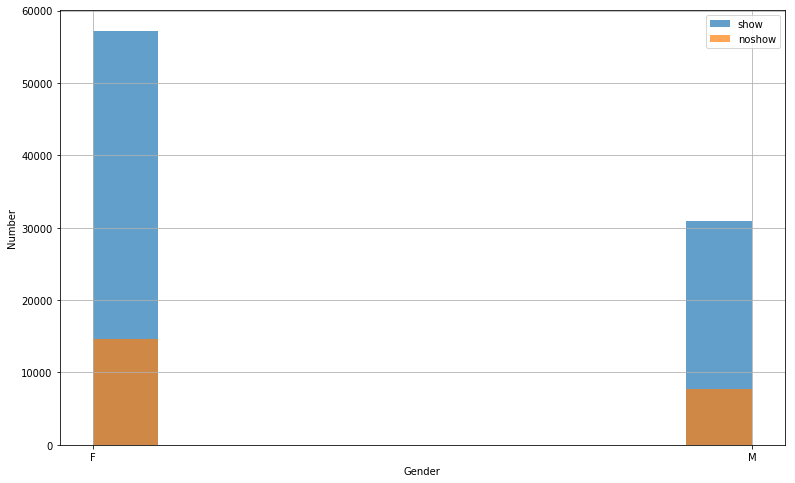

In [164]:
# Does sex affect attendance?
plt.figure(figsize=[13, 8])
df.Gender[show].hist(alpha = 0.7, label = 'show')
df.Gender[noshow].hist(alpha = 0.7,label = 'noshow')
plt.legend()
plt.xlabel("Gender")
plt.ylabel("Number")

It doesn't affect.

 # Do chronic diseases affect attendance?

Text(0,0.5,'Number')

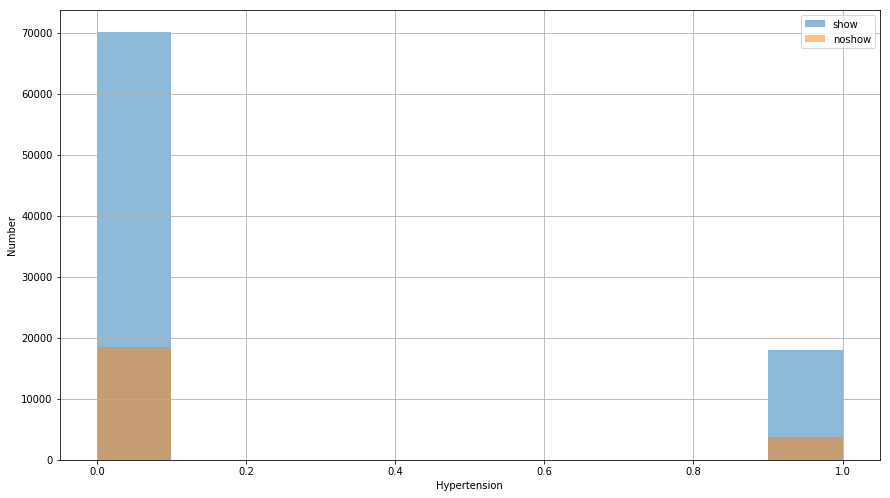

In [158]:
plt.figure(figsize=[14.7, 8.27])
df.Hypertension[show].hist(alpha = 0.5, label = 'show')
df.Hypertension[noshow].hist(alpha = 0.5,label = 'noshow')
plt.legend()
plt.xlabel("Hypertension")
plt.ylabel(" Number")


Text(0,0.5,'Number')

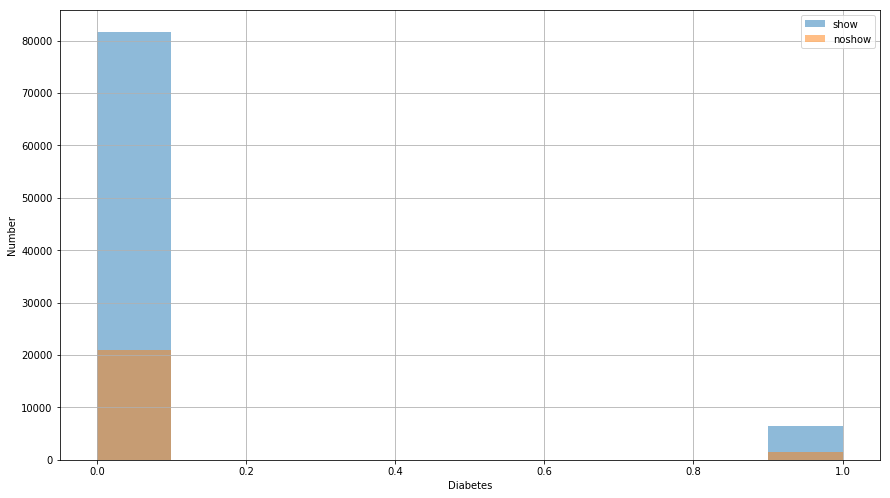

In [159]:
plt.figure(figsize=[14.7, 8.27])
df.Diabetes[show].hist(alpha = 0.5, label = 'show')
df.Diabetes[noshow].hist(alpha = 0.5,label = 'noshow')
plt.legend()
plt.xlabel("Diabetes")
plt.ylabel("Number")

It doesn't affect.

Text(0,0.5,'Number')

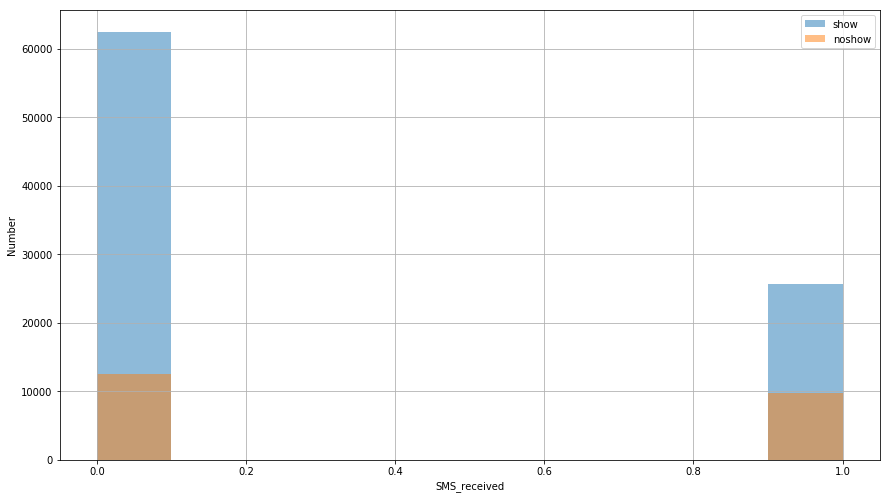

In [166]:
# Do sms messages affect attendance ?
plt.figure(figsize=[14.7, 8.27])
df.SMS_received[show].hist(alpha = 0.5, label = 'show')
df.SMS_received[noshow].hist(alpha = 0.5,label = 'noshow')
plt.legend()
plt.xlabel("SMS_received")
plt.ylabel("Number")

number of those who not recived sms massege is less than those not recived.

<a id='conclusions'></a>
## Conclusions

> **Tip**: patients attendance differce Not related to chronic diseases, age or sex .


> **Tip**:The total number of people who received less-attended sms messages than those who did not receive those messages That means sms message is an ineffectual idea. 

> **Tip**: The main element in the presence of patients is the age and the oldest is the highest rate of attendance

> **Tip**:This data lacks a lot of information that helps us analyze the reasons for attendance more accurately.



In [168]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0